In [1]:
from IPython.display import Image

# Overview
This code implements the PIML regresson procedure described in Wang et al. 2017, with the case of flow over periodic hills as example. 

* J.-X. Wang, J.-L. Wu, and H. Xiao. Physics informed machine learning approach for reconstructing Reynolds stress modeling discrepancies based on DNS data. Physical Review Fluids. 2(3), 034603, 1-22, 2017. https://doi.org/10.1103/PhysRevFluids.2.034603[DOI:10.1103/PhysRevFluids.2.034603]

# Algorithm of PIML-Based Turbulence Modeling
The overall procedure can be summarized as follows:

1. Perform baseline RANS simulations on both the training flows and the test flow.
1. Compute the input feature field $\mathbf{q}(\mathbf{x})$ based on the local 
 	RANS flow variables. 
1. Compute the discrepancies field $\Delta \boldsymbol{\tau}(\mathbf{x})$ in the RANS-modeled 
 	Reynolds stresses for the training flows based on the high-fidelity data.
1. **Construct regression functions $ f: \mathbf{q} \mapsto \Delta \boldsymbol{\tau}$ for the
 	discrepancies based on the training data prepared in Step 3, using machine learning algorithms.**
1. Compute the Reynolds stress discrepancies for the test flow by querying the regression
 	functions. The Reynolds stresses can subsequently be obtained by correcting the baseline RANS 
 	predictions with the evaluated discrepancies.
1. Propagate the corrected Reynolds stresses to the mean velocity field by solving the RANS 
 	equations with the corrected Reynolds stress field.


**This code only performs Step 4.** (see the green-shaded box below in the flow chart). The training data prepared in Steps 1-3 are saved in _database_ folder.


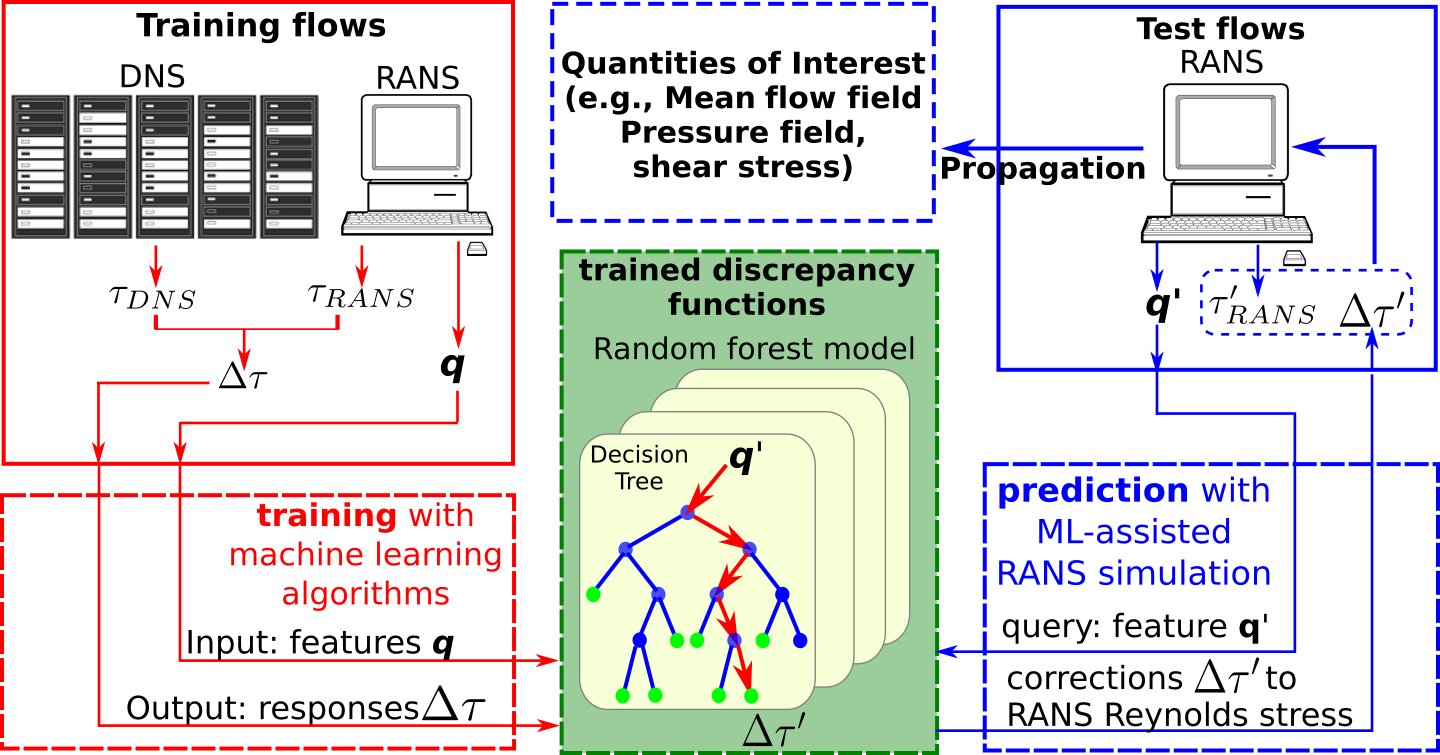

In [2]:
Image(filename='figs/PIML-algorithm.png')

# Machine learning algorithms

The procedure implented here consists of three parts:

1. load training and test data
2. construct regression function $\Delta \boldsymbol{\tau} (\mathbf{q})$ (detailed below)
3. plot the anisotropy parameters $\xi$ and $\eta$ (componebnts of $\Delta \boldsymbol{\tau}$) and compare with ground truth (DNS)

We used two algorithms to build the regression function: 

* Random Forests (based on scikit-learn). This is what was used in Wang et al.
* Neural networks (based on Tensorflow)

Both algorithms yielded similar results, but the former is cheaper computationally.

The input features consist of 12 variables (see Table 1 below and also Wang et al.)

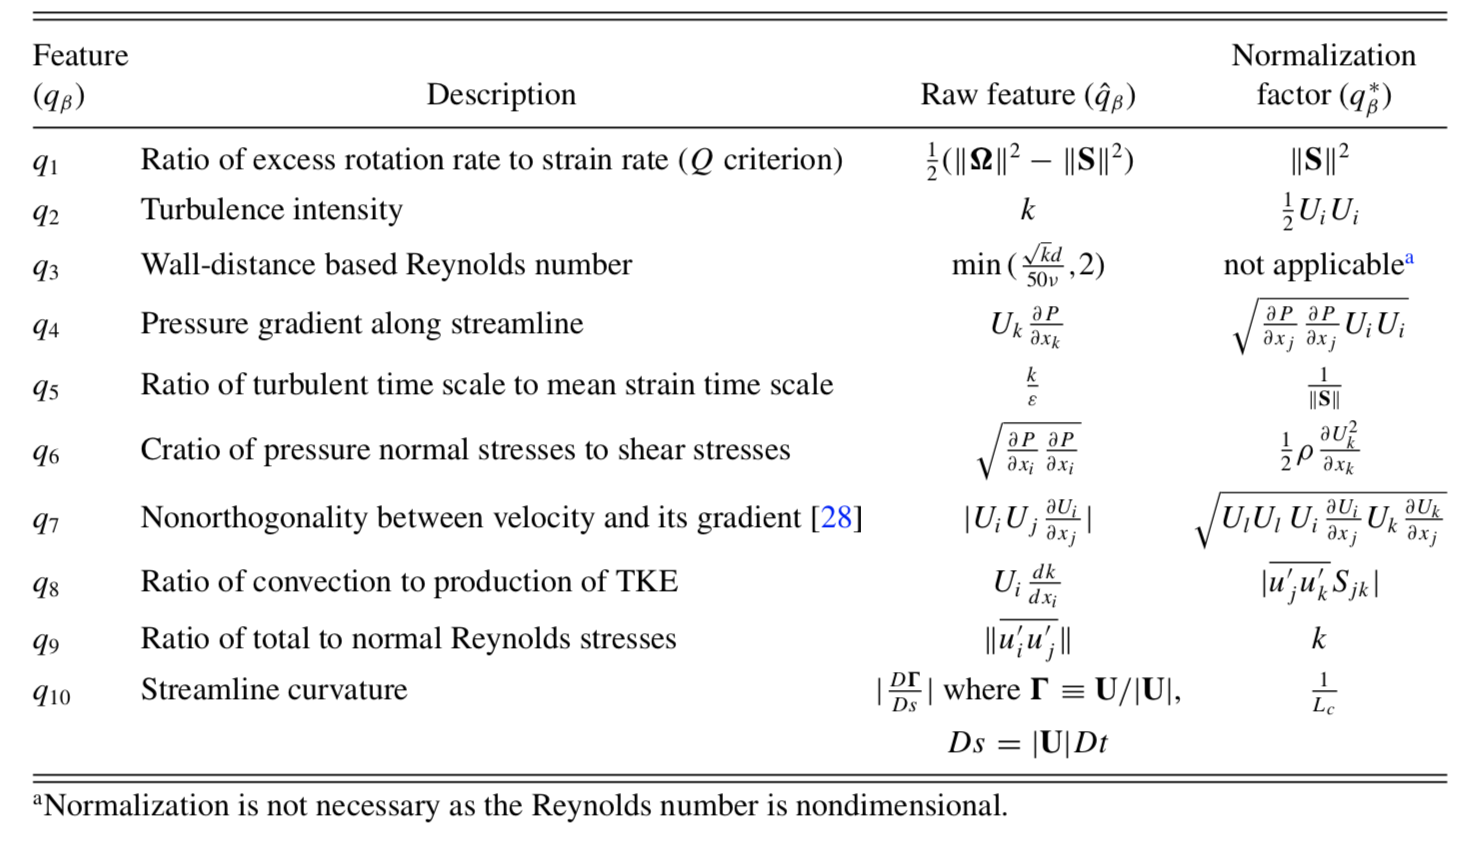

In [3]:
Image(filename='figs/features.png')

In [4]:
%matplotlib inline
## Import system modules
# sci computing
import numpy as np
# sklearn importing
from sklearn.ensemble.forest import RandomForestRegressor
# plotting
import matplotlib.pyplot as plt  # for plotting
#import matplotlib as mp

# keras importing
from keras.models import Sequential
from keras.layers import Dense

import time

Using TensorFlow backend.


In [5]:
def loadTrainingData(caseName, ReNum):
    trainFeaturesFile = './database/' + caseName + '/markers/' + ReNum + '/markerFile'
    trainResponsesFile = './database/' + caseName + '/deltaFields/' + ReNum + '/deltaField'
    trainFeatures = np.loadtxt(trainFeaturesFile)
    trainResponses = np.loadtxt(trainResponsesFile)
    return trainFeatures, trainResponses

In [6]:
def loadTestData(caseName, ReNum):
    testFeaturesFile = './database/' + caseName + '/markers/' + ReNum + '/markerFile'
    testResponsesFile = './database/' + caseName + '/deltaFields/' + ReNum + '/deltaField'
    testFeatures = np.loadtxt(testFeaturesFile)
    testResponses = np.loadtxt(testResponsesFile)
    return testFeatures, testResponses

In [7]:
def randomForest(trainFeatures, trainResponses, testFeatures, maxFeatures = 'log2', nTree=100):
    ## Settings of random forests regressor
    regModel = RandomForestRegressor(n_estimators=nTree, max_features=maxFeatures)    
    ## Train the random forests regressor
    regModel.fit(trainFeatures, trainResponses)
    ## Prediction
    testResponsesPred = regModel.predict(testFeatures)
    return testResponsesPred

In [8]:
def keras_nn(trainFeatures, trainResponses, testFeatures):
    
    '''
    This function is to construct neural network based on the training data and predict the 
    response given test data.
    Two hidded layers are used, the number of neurals are 64 and 32, respectively.
    '''
    model = Sequential()
    # The first hidder layer of NN
    model.add(Dense(64, input_dim=trainFeatures.shape[1], activation='relu'))
    # The second hidder layer of NN
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Training
    model.fit(trainFeatures, trainResponses, epochs=100000, batch_size=200, verbose=0)
    # Prediction
    testResponsesPred = model.predict(testFeatures)
    return testResponsesPred

In [19]:
def plotXiEta(XiEta_RANS, testResponses, testResponsesPred, name):
    # Reconstruct Barycentric coordinates
    XiEta_DNS = XiEta_RANS + testResponses
    XiEta_ML = XiEta_RANS + testResponsesPred
    # Plot Reynolds stress anisotropy in Barycentric triangle
    interval = 2
    pointsNum = int(XiEta_RANS.shape[0])
    plt.figure()
    plt.plot([0,1,0.5,0.5,0],[0,0,3**0.5/2.0,3**0.5/2.0,0],'g-')
    p1, = plt.plot(XiEta_RANS[:pointsNum:interval,0],XiEta_RANS[:pointsNum:interval,1],
                   'bo', markerfacecolor='none', markeredgecolor='b',
                   markeredgewidth=2, markersize=10)
    p2, = plt.plot(XiEta_DNS[:pointsNum:interval,0],XiEta_DNS[:pointsNum:interval,1],
                   'ks', markerfacecolor='none', markeredgecolor='k',
                   markeredgewidth=2, markersize=10)
    p3, = plt.plot(XiEta_ML[:pointsNum:interval,0],XiEta_ML[:pointsNum:interval,1],
                   'r^', markerfacecolor='none', markeredgecolor='r',
                   markeredgewidth=2, markersize=10)
    lg = plt.legend([p1,p2,p3], ['RANS', 'DNS', name], loc = 0)
    lg.draw_frame(False)
    plt.ylim([0,3**0.5/2.0])
    plt.show()
    
def comparePlot(XiEta_RANS, testResponses, testResponsesPred_RF, testResponsesPred_NN):
    
    XiEta_DNS = XiEta_RANS + testResponses
    XiEta_RF = XiEta_RANS + testResponsesPred_RF
    XiEta_NN = XiEta_RANS + testResponsesPred_NN
    # Plot Reynolds stress anisotropy in Barycentric triangle
    interval = 2
    pointsNum = int(XiEta_RANS.shape[0])
    plt.figure()
    plt.plot([0,1,0.5,0.5,0],[0,0,3**0.5/2.0,3**0.5/2.0,0],'g-')
    p1, = plt.plot(XiEta_RANS[:pointsNum:interval,0],XiEta_RANS[:pointsNum:interval,1],
                   'bo', markerfacecolor='none', markeredgecolor='b',
                   markeredgewidth=1.5, markersize=8)
    p2, = plt.plot(XiEta_DNS[:pointsNum:interval,0],XiEta_DNS[:pointsNum:interval,1],
                   'ks', markerfacecolor='none', markeredgecolor='k',
                   markeredgewidth=1.5, markersize=8)
    p3, = plt.plot(XiEta_RF[:pointsNum:interval,0],XiEta_RF[:pointsNum:interval,1],
                   'r^', markerfacecolor='none', markeredgecolor='r',
                   markeredgewidth=1.5, markersize=8)
    p4, = plt.plot(XiEta_NN[:pointsNum:interval,0],XiEta_NN[:pointsNum:interval,1],
                   'r+', markerfacecolor='none', markeredgecolor='g',
                   markeredgewidth=1.5, markersize=8)
    lg = plt.legend([p1,p2,p3, p4], ['RANS', 'DNS', 'RF', 'NN'], loc = 0)
    lg.draw_frame(False)
    plt.ylim([0,3**0.5/2.0])
    plt.show()

def iterateLines(dataFolderRANS, testResponses, testResponsesPred, name):
    # Start index of different sample lines
    indexList = [0, 98, 191, 287, 385, 483, 581, 679, 777, 875, 971]
    # Make plots at x=2 and x=4
    for iterN in [3,5]:
        XiEta = np.loadtxt(dataFolderRANS + 'line' + str(iterN) + '_XiEta.xy')
        startIndex = indexList[iterN-1]
        endIndex = indexList[iterN]
        plotXiEta(XiEta, testResponses[startIndex:endIndex,:], 
                         testResponsesPred[startIndex:endIndex,:], name)
    #plt.show()

def compareResults(dataFolderRANS, testResponses, testResponsesPred_RF, testResponsesPred_NN):
    ## compare the results in one plot
    # Start index of different sample lines
    indexList = [0, 98, 191, 287, 385, 483, 581, 679, 777, 875, 971]
    # Make plots at x=2 and x=4
    for iterN in [3,5]:
        XiEta = np.loadtxt(dataFolderRANS + 'line' + str(iterN) + '_XiEta.xy')
        startIndex = indexList[iterN-1]
        endIndex = indexList[iterN]
        comparePlot(XiEta, testResponses[startIndex:endIndex,:], 
                    testResponsesPred_RF[startIndex:endIndex,:], 
                    testResponsesPred_NN[startIndex:endIndex,:])

Now, plot the anisotropy at the two locations $x/H = 2$ and 4:

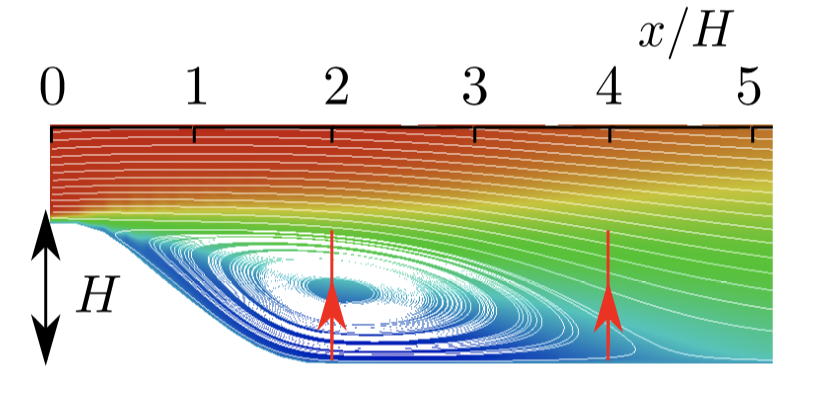

In [10]:
Image(filename='figs/locations.png')

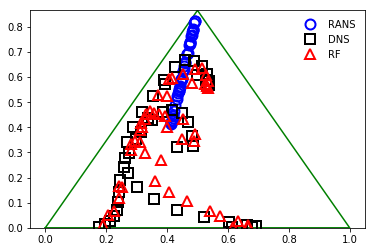

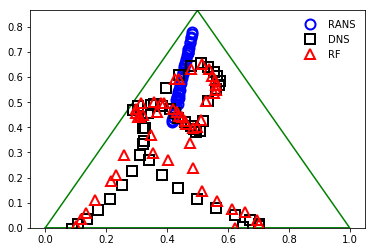

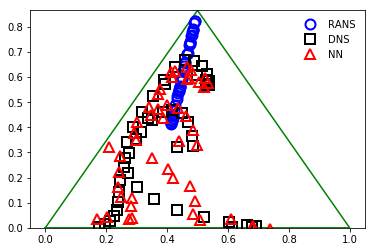

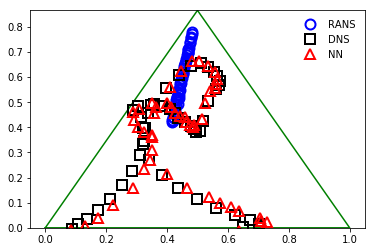

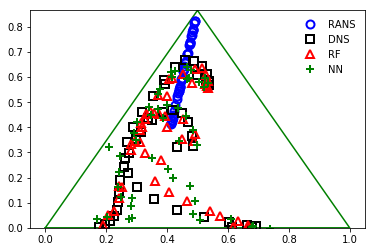

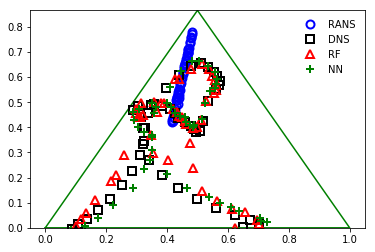

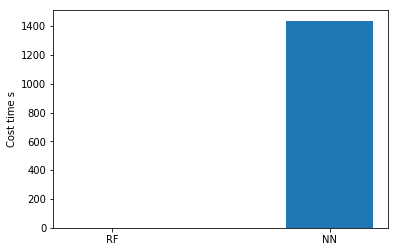

In [29]:
if __name__== "__main__":
    # Load data
    trainFeatures, trainResponses = loadTrainingData('pehill', 'Re5600')
    testFeatures, testResponses = loadTestData('pehill', 'Re10595')
    time_begin_RF = time.time()
    # Make prediction via the random forest regressor
    testResponsesPred_RF = randomForest(trainFeatures, trainResponses, testFeatures, 6, 100)
    time_end_RF = time.time()
    # Make plots of Reynolds stress anisotropy
    dataFolderRANS = './database/pehill/XiEta-RANS/Re10595/'
    iterateLines(dataFolderRANS, testResponses, testResponsesPred_RF, name='RF')
    
    time_begin_NN = time.time()
    # Make prediction via the neural network
    testResponsesPred_NN = keras_nn(trainFeatures, trainResponses, testFeatures)
    time_end_NN = time.time()
    # Make plots of Reynolds stress anisotropy
    dataFolderRANS = './database/pehill/XiEta-RANS/Re10595/'
    iterateLines(dataFolderRANS, testResponses, testResponsesPred_NN, name='NN')
    # The cost time of calculation
    cost_time_RF = time_end_RF - time_begin_RF
    cost_time_NN = time_end_NN - time_begin_NN
    # Compare the results of random forest and neural network
    compareResults(dataFolderRANS, testResponses, testResponsesPred_RF, testResponsesPred_NN)
    
    xlabel = np.arange(2)
    plt.bar(xlabel, [cost_time_RF, cost_time_NN], 0.4)
    plt.ylabel('Cost time s')
    plt.xticks(xlabel, ('RF', 'NN'))
    plt.show()